In [19]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost,lightgbm,catboost

In [20]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('SampleSubmission.csv')
#des = pd.read_csv('VariableDescription')

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25053 entries, 0 to 25052
Columns: 121 entries, BCT_CODBUR to id
dtypes: float64(103), int64(16), object(2)
memory usage: 23.1+ MB


In [22]:
train.head()

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,target,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,id
0,49,14185,P,99,1,6101,4,2,2,2,...,13.575957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id0
1,221,6032,P,99,0,6271,8,2,1,1,...,11.692894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id1
2,181,8907,P,99,0,6102,4,2,2,2,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id2
3,252,5783,M,22,0,4403,4,2,2,2,...,16.237871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id3
4,234,1477,P,99,0,6312,8,2,2,1,...,13.399983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id4


# Data Preparation

# Dropping the columns that has missing values more than 16000

In [23]:

def drop_cols():
    drop_col = [columns for columns in train.columns[train.isnull().sum()>16000]]

    train.drop(drop_col, axis=1, inplace=True)
    test.drop(drop_col, axis=1, inplace=True)
    print("%f columns were dropped"%(len(drop_col)))
drop_cols()

30.000000 columns were dropped


In [24]:
# Filling the missing values
train = train.fillna(-999)
test = test.fillna(-999)

In [25]:
train.isna().sum()

BCT_CODBUR      0
CTR_MATFIS      0
CTR_CATEGO_X    0
FJU_CODFJU      0
CTR_CESSAT      0
               ..
AX3_REVCAP      0
AX5_MNTMAR      0
RES_ANNIMP      0
target          0
id              0
Length: 91, dtype: int64

In [26]:
test.isna().sum()

BCT_CODBUR      0
CTR_MATFIS      0
CTR_CATEGO_X    0
FJU_CODFJU      0
CTR_CESSAT      0
               ..
AX2_LOYERS      0
AX3_REVCAP      0
AX5_MNTMAR      0
RES_ANNIMP      0
id              0
Length: 90, dtype: int64

In [27]:
Xnew = train.shape[0]
ynew = test.shape[0]

In [28]:
# Concatenating both the test and train
# Concatenating the train and test together
new_data = pd.concat((train,test)).reset_index(drop=True)
new_data.shape

# Drop the  target column
new_data.drop(['target'], axis=1, inplace=True)
new_data.shape

(35791, 90)

# checking for categorical variables
# Using One Hot encoding

In [ ]:
new_data.columns[new_data.dtypes == 'object']

pd.get_dummies(new_data,new_data.columns[new_data.dtypes == 'object'])

In [ ]:
# To check for unique values of each column
for i in new_data.columns[new_data.dtypes == 'object']:
    print(i, '::',new_data[i].unique())

In [ ]:
new_data2 = new_data

In [ ]:
# Using Categorical dtypes
for i in train.columns[train.dtypes == 'object']:
    print(i, '::')
    new_data2[i]= new_data[i].astype('category')
    new_data2[i] = new_data2[i].cat.codes

In [ ]:
new_data.CTR_CATEGO_X.head()

In [ ]:
test.dtypes

In [ ]:
new_data2.dtypes

In [ ]:
# to find the categorical column
#new_data.select_dtypes(exclude = ['number'])

# Using one hot encoding without sklearn
# x.factorize() is a pandas way to achieve label encoding without using sklearn
#train['CTR_CATEGO_X']=train['CTR_CATEGO_X'].factorize()[0]
#test['CTR_CATEGO_X']= test['CTR_CATEGO_X'].factorize()[0]

In [ ]:
X = new_data2[:Xnew]
ytest = new_data2[Xnew:]

print('The train size: ' + str(X.shape))
print('The test size: ' + str(ytest.shape))

In [ ]:
y = train['target']

# Model and Accuracy Using KFold

# Base Model

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [ ]:
xgb = XGBRegressor(learning_rate=0.05)
lgb = LGBMRegressor()
rf = RandomForestRegressor()
cat = CatBoostRegressor()

In [28]:
xgb.fit(X_train,y_train)
xgb.fit(X_train,y_train, eval_metric ='rmse' , eval_set = [(X_train,y_train),(X_test,y_test)], 
        early_stopping_rounds = 100)

[19:27:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:27:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12.335	validation_1-rmse:12.2594
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.4438	validation_1-rmse:11.3718
[2]	validation_0-rmse:10.665	validation_1-rmse:10.5968
[3]	validation_0-rmse:9.99069	validation_1-rmse:9.92622
[4]	validation_0-rmse:9.40722	validation_1-rmse:9.34602
[5]	validation_0-rmse:8.90531	validation_1-rmse:8.8478
[6]	validation_0-rmse:8.47564	validation_1-rmse:8.42216
[7]	validation_0-rmse:8.1094	validation_1-rmse:8.05939
[8]	validation_0-rmse:7.79983	validation_1-rmse:7.7515
[9]	validation_0-rmse:7.53566	validation_1-rmse:7.49169
[10]	validation_0-rmse:7.31435	validation_1-rmse:7.27

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [29]:
lgb.fit(X_train,y_train)
lgb.fit(X_train,y_train, eval_metric ='rmse' ,
        eval_set = [(X_train,y_train),(X_test,y_test)], 
        early_stopping_rounds = 500)

[1]	training's rmse: 6.90724	training's l2: 47.71	valid_1's rmse: 6.95616	valid_1's l2: 48.3882
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 6.7716	training's l2: 45.8546	valid_1's rmse: 6.81933	valid_1's l2: 46.5032
[3]	training's rmse: 6.65745	training's l2: 44.3216	valid_1's rmse: 6.70681	valid_1's l2: 44.9814
[4]	training's rmse: 6.56107	training's l2: 43.0476	valid_1's rmse: 6.61474	valid_1's l2: 43.7547
[5]	training's rmse: 6.47918	training's l2: 41.9797	valid_1's rmse: 6.53288	valid_1's l2: 42.6785
[6]	training's rmse: 6.40746	training's l2: 41.0556	valid_1's rmse: 6.46077	valid_1's l2: 41.7416
[7]	training's rmse: 6.34426	training's l2: 40.2497	valid_1's rmse: 6.40464	valid_1's l2: 41.0195
[8]	training's rmse: 6.29176	training's l2: 39.5862	valid_1's rmse: 6.35476	valid_1's l2: 40.383
[9]	training's rmse: 6.24631	training's l2: 39.0164	valid_1's rmse: 6.31521	valid_1's l2: 39.8819
[10]	training's rmse: 6.2041	training's l2: 38.4908	valid_1'

[86]	training's rmse: 5.34724	training's l2: 28.5929	valid_1's rmse: 5.91861	valid_1's l2: 35.03
[87]	training's rmse: 5.34008	training's l2: 28.5165	valid_1's rmse: 5.918	valid_1's l2: 35.0228
[88]	training's rmse: 5.33513	training's l2: 28.4637	valid_1's rmse: 5.91876	valid_1's l2: 35.0318
[89]	training's rmse: 5.33092	training's l2: 28.4187	valid_1's rmse: 5.91822	valid_1's l2: 35.0253
[90]	training's rmse: 5.32642	training's l2: 28.3708	valid_1's rmse: 5.91829	valid_1's l2: 35.0262
[91]	training's rmse: 5.32107	training's l2: 28.3138	valid_1's rmse: 5.91815	valid_1's l2: 35.0244
[92]	training's rmse: 5.31337	training's l2: 28.2319	valid_1's rmse: 5.91656	valid_1's l2: 35.0057
[93]	training's rmse: 5.30721	training's l2: 28.1665	valid_1's rmse: 5.91663	valid_1's l2: 35.0065
[94]	training's rmse: 5.29985	training's l2: 28.0884	valid_1's rmse: 5.91505	valid_1's l2: 34.9879
[95]	training's rmse: 5.29295	training's l2: 28.0153	valid_1's rmse: 5.91286	valid_1's l2: 34.9619
[96]	training'

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [31]:
cat.fit(X_train,y_train)

0:	learn: 13.4610825	total: 1.86s	remaining: 31m 4s
1:	learn: 13.1555771	total: 4.46s	remaining: 37m 3s
2:	learn: 12.8630928	total: 6.82s	remaining: 37m 48s
3:	learn: 12.5818199	total: 8.94s	remaining: 37m 6s
4:	learn: 12.3097861	total: 10.9s	remaining: 36m 18s
5:	learn: 12.0461438	total: 12.7s	remaining: 35m 2s
6:	learn: 11.7915799	total: 14.4s	remaining: 34m
7:	learn: 11.5515235	total: 16.8s	remaining: 34m 42s
8:	learn: 11.3177812	total: 19.7s	remaining: 36m 12s
9:	learn: 11.0944101	total: 22.8s	remaining: 37m 37s
10:	learn: 10.8768379	total: 24.4s	remaining: 36m 35s
11:	learn: 10.6707823	total: 26.4s	remaining: 36m 12s
12:	learn: 10.4694665	total: 29.6s	remaining: 37m 24s
13:	learn: 10.2773075	total: 32.4s	remaining: 38m
14:	learn: 10.0935021	total: 34.8s	remaining: 38m 3s
15:	learn: 9.9174502	total: 37.1s	remaining: 38m 2s
16:	learn: 9.7484940	total: 38.7s	remaining: 37m 18s
17:	learn: 9.5863093	total: 39.3s	remaining: 35m 45s
18:	learn: 9.4324150	total: 40.9s	remaining: 35m 11s
19

153:	learn: 6.1555789	total: 5m 52s	remaining: 32m 14s
154:	learn: 6.1547899	total: 5m 54s	remaining: 32m 13s
155:	learn: 6.1527183	total: 5m 57s	remaining: 32m 12s
156:	learn: 6.1516585	total: 5m 59s	remaining: 32m 8s
157:	learn: 6.1498336	total: 6m	remaining: 32m 3s
158:	learn: 6.1474323	total: 6m 3s	remaining: 32m 3s
159:	learn: 6.1461399	total: 6m 6s	remaining: 32m 4s
160:	learn: 6.1447529	total: 6m 10s	remaining: 32m 12s
161:	learn: 6.1434640	total: 6m 13s	remaining: 32m 11s
162:	learn: 6.1418738	total: 6m 15s	remaining: 32m 6s
163:	learn: 6.1401849	total: 6m 16s	remaining: 32m
164:	learn: 6.1383636	total: 6m 19s	remaining: 31m 58s
165:	learn: 6.1369871	total: 6m 21s	remaining: 31m 55s
166:	learn: 6.1357724	total: 6m 23s	remaining: 31m 54s
167:	learn: 6.1342072	total: 6m 25s	remaining: 31m 48s
168:	learn: 6.1328180	total: 6m 26s	remaining: 31m 41s
169:	learn: 6.1322267	total: 6m 28s	remaining: 31m 34s
170:	learn: 6.1306840	total: 6m 29s	remaining: 31m 30s
171:	learn: 6.1295306	tot

303:	learn: 6.0294428	total: 11m 12s	remaining: 25m 39s
304:	learn: 6.0287892	total: 11m 14s	remaining: 25m 36s
305:	learn: 6.0281152	total: 11m 15s	remaining: 25m 32s
306:	learn: 6.0276234	total: 11m 17s	remaining: 25m 28s
307:	learn: 6.0267586	total: 11m 19s	remaining: 25m 26s
308:	learn: 6.0266243	total: 11m 21s	remaining: 25m 23s
309:	learn: 6.0260058	total: 11m 23s	remaining: 25m 21s
310:	learn: 6.0256951	total: 11m 25s	remaining: 25m 18s
311:	learn: 6.0251028	total: 11m 27s	remaining: 25m 15s
312:	learn: 6.0242357	total: 11m 28s	remaining: 25m 11s
313:	learn: 6.0234581	total: 11m 29s	remaining: 25m 7s
314:	learn: 6.0226976	total: 11m 31s	remaining: 25m 4s
315:	learn: 6.0220834	total: 11m 34s	remaining: 25m 2s
316:	learn: 6.0217998	total: 11m 36s	remaining: 25m
317:	learn: 6.0206483	total: 11m 38s	remaining: 24m 58s
318:	learn: 6.0200821	total: 11m 40s	remaining: 24m 56s
319:	learn: 6.0198743	total: 11m 42s	remaining: 24m 53s
320:	learn: 6.0197843	total: 11m 45s	remaining: 24m 51s

451:	learn: 5.9418414	total: 17m 5s	remaining: 20m 43s
452:	learn: 5.9408143	total: 17m 9s	remaining: 20m 42s
453:	learn: 5.9406639	total: 17m 12s	remaining: 20m 42s
454:	learn: 5.9403399	total: 17m 15s	remaining: 20m 39s
455:	learn: 5.9396455	total: 17m 17s	remaining: 20m 38s
456:	learn: 5.9394980	total: 17m 19s	remaining: 20m 35s
457:	learn: 5.9394086	total: 17m 20s	remaining: 20m 31s
458:	learn: 5.9393227	total: 17m 22s	remaining: 20m 28s
459:	learn: 5.9388504	total: 17m 23s	remaining: 20m 25s
460:	learn: 5.9382514	total: 17m 26s	remaining: 20m 23s
461:	learn: 5.9379536	total: 17m 28s	remaining: 20m 20s
462:	learn: 5.9369136	total: 17m 31s	remaining: 20m 19s
463:	learn: 5.9365689	total: 17m 33s	remaining: 20m 16s
464:	learn: 5.9357377	total: 17m 35s	remaining: 20m 14s
465:	learn: 5.9348565	total: 17m 37s	remaining: 20m 11s
466:	learn: 5.9335067	total: 17m 40s	remaining: 20m 10s
467:	learn: 5.9333732	total: 17m 43s	remaining: 20m 9s
468:	learn: 5.9329692	total: 17m 46s	remaining: 20m

599:	learn: 5.8732703	total: 22m 54s	remaining: 15m 16s
600:	learn: 5.8730183	total: 22m 55s	remaining: 15m 13s
601:	learn: 5.8727548	total: 22m 58s	remaining: 15m 11s
602:	learn: 5.8725362	total: 23m	remaining: 15m 9s
603:	learn: 5.8723901	total: 23m 2s	remaining: 15m 6s
604:	learn: 5.8723302	total: 23m 4s	remaining: 15m 3s
605:	learn: 5.8715943	total: 23m 5s	remaining: 15m
606:	learn: 5.8711497	total: 23m 7s	remaining: 14m 58s
607:	learn: 5.8708529	total: 23m 8s	remaining: 14m 55s
608:	learn: 5.8706514	total: 23m 10s	remaining: 14m 53s
609:	learn: 5.8701776	total: 23m 13s	remaining: 14m 50s
610:	learn: 5.8696900	total: 23m 15s	remaining: 14m 48s
611:	learn: 5.8692635	total: 23m 17s	remaining: 14m 46s
612:	learn: 5.8691081	total: 23m 18s	remaining: 14m 43s
613:	learn: 5.8691017	total: 23m 19s	remaining: 14m 39s
614:	learn: 5.8685693	total: 23m 20s	remaining: 14m 36s
615:	learn: 5.8684717	total: 23m 22s	remaining: 14m 34s
616:	learn: 5.8681213	total: 23m 24s	remaining: 14m 32s
617:	lea

747:	learn: 5.8264127	total: 28m 44s	remaining: 9m 41s
748:	learn: 5.8258873	total: 28m 47s	remaining: 9m 38s
749:	learn: 5.8254339	total: 28m 49s	remaining: 9m 36s
750:	learn: 5.8250864	total: 28m 51s	remaining: 9m 34s
751:	learn: 5.8241520	total: 28m 53s	remaining: 9m 31s
752:	learn: 5.8238607	total: 28m 56s	remaining: 9m 29s
753:	learn: 5.8236371	total: 28m 59s	remaining: 9m 27s
754:	learn: 5.8234450	total: 29m 1s	remaining: 9m 25s
755:	learn: 5.8233717	total: 29m 3s	remaining: 9m 22s
756:	learn: 5.8231808	total: 29m 5s	remaining: 9m 20s
757:	learn: 5.8223306	total: 29m 6s	remaining: 9m 17s
758:	learn: 5.8219094	total: 29m 9s	remaining: 9m 15s
759:	learn: 5.8213407	total: 29m 11s	remaining: 9m 13s
760:	learn: 5.8208693	total: 29m 13s	remaining: 9m 10s
761:	learn: 5.8208161	total: 29m 15s	remaining: 9m 8s
762:	learn: 5.8207371	total: 29m 17s	remaining: 9m 5s
763:	learn: 5.8206424	total: 29m 19s	remaining: 9m 3s
764:	learn: 5.8201252	total: 29m 21s	remaining: 9m 1s
765:	learn: 5.81993

897:	learn: 5.7909728	total: 35m 11s	remaining: 3m 59s
898:	learn: 5.7908753	total: 35m 12s	remaining: 3m 57s
899:	learn: 5.7908618	total: 35m 13s	remaining: 3m 54s
900:	learn: 5.7905051	total: 35m 15s	remaining: 3m 52s
901:	learn: 5.7904143	total: 35m 17s	remaining: 3m 50s
902:	learn: 5.7903708	total: 35m 20s	remaining: 3m 47s
903:	learn: 5.7900317	total: 35m 23s	remaining: 3m 45s
904:	learn: 5.7899347	total: 35m 25s	remaining: 3m 43s
905:	learn: 5.7897396	total: 35m 27s	remaining: 3m 40s
906:	learn: 5.7886758	total: 35m 30s	remaining: 3m 38s
907:	learn: 5.7886067	total: 35m 33s	remaining: 3m 36s
908:	learn: 5.7884670	total: 35m 36s	remaining: 3m 33s
909:	learn: 5.7881305	total: 35m 39s	remaining: 3m 31s
910:	learn: 5.7876636	total: 35m 41s	remaining: 3m 29s
911:	learn: 5.7876349	total: 35m 42s	remaining: 3m 26s
912:	learn: 5.7875750	total: 35m 45s	remaining: 3m 24s
913:	learn: 5.7875202	total: 35m 47s	remaining: 3m 22s
914:	learn: 5.7871222	total: 35m 49s	remaining: 3m 19s
915:	learn

In [32]:
# Prediction
xgbpred = xgb.predict(X_test)
lgbpred = lgb.predict(X_test)
rfpred = rf.predict(X_test)
catpred = cat.predict(X_test)

In [33]:
# Prediction
xgbpredt = xgb.predict(X_train)
lgbpredt = lgb.predict(X_train)
rfpredt = rf.predict(X_train)
catpredt = cat.predict(X_train)

In [34]:
# Prediction
xgbpredtt = xgb.predict(X)
lgbpredtt = lgb.predict(X)
rfpredtt = rf.predict(X)
catpredtt = cat.predict(X)

In [37]:
# Creating a function for a Root Mean Square Error

from sklearn.metrics import mean_squared_error as mse
def rmse(ylabel,y_pred):
    return np.sqrt(mse(ylabel, y_pred))

In [54]:
print('Validation scores is: ', rmse(y_test,xgbpred))
print('Trainning scores is: ', rmse(y_train,xgbpredt))
#print('Accuracy score: ', accuracy_score(xgbpred,y_test))

Validation scores is:  6.06575836627224
Trainning scores is:  5.952498693145752


In [55]:
print('Validation scores is: ', rmse(y_test,lgbpred))
print('Trainning scores is: ', rmse(y_train,lgbpredt))

Validation scores is:  5.904849120194917
Trainning scores is:  5.2620660113521


In [56]:
print('Validation scores is: ', rmse(y_test,rfpred))
print('Trainning scores is: ', rmse(y_train,rfpredt))

Validation scores is:  5.7909615375845975
Trainning scores is:  2.19784560475937


In [57]:
print('Validation scores is: ', rmse(y_test,catpred))
print('Trainning scores is: ', rmse(y_train,catpredt))

Validation scores is:  6.00277826258047
Trainning scores is:  5.766614342540184


In [58]:
print('XGB >>>',rmse(y_test,xgbpred))
print('LGB >>>',rmse(y_test,lgbpred))
print('CAT >>>',rmse(y_test,catpred))
print('RF >>>',rmse(y_test,rfpred))

XGB >>> 6.06575836627224
LGB >>> 5.904849120194917
CAT >>> 6.00277826258047
RF >>> 5.7909615375845975


In [59]:
print('XGB >>>',rmse(y,xgbpredtt))
print('LGB >>>',rmse(y,lgbpredtt))
print('CAT >>>',rmse(y,catpredtt))
print('RF >>>',rmse(y,rfpredtt))

XGB >>> 5.97532419187361
LGB >>> 5.39676145444898
CAT >>> 5.814618347959458
RF >>> 3.251449776884854


# Features importance

In [60]:
features = [col for col in train.columns if col not in ['target']]

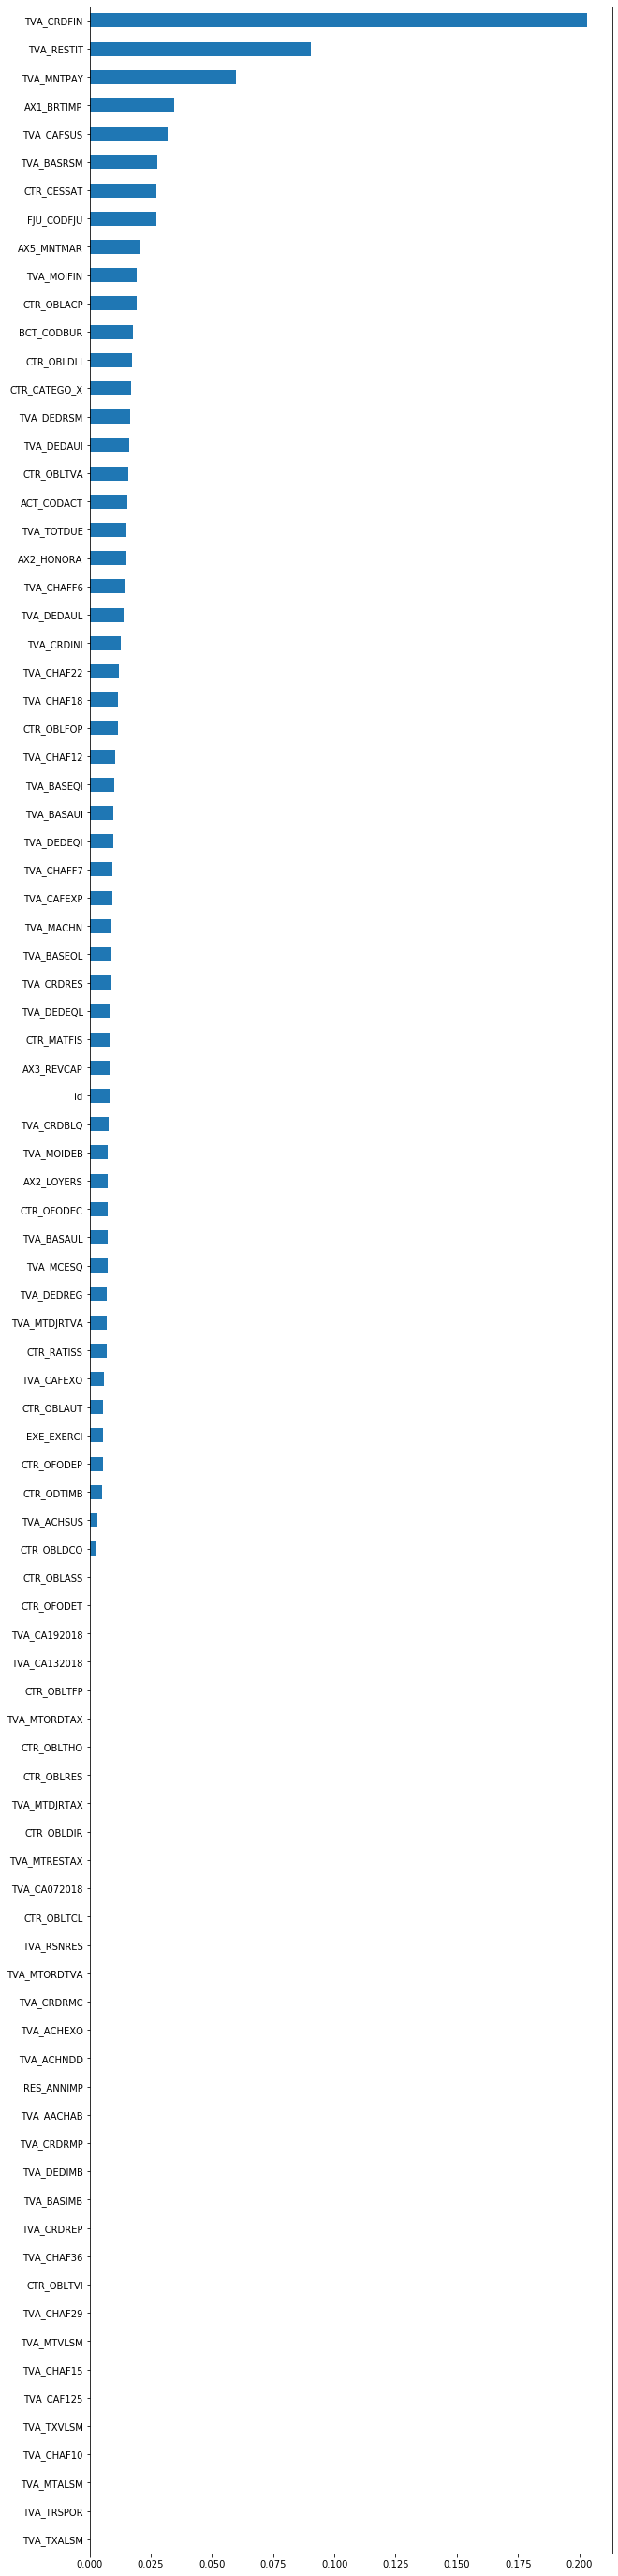

In [61]:
fi = pd.Series(index=features, data= xgb.feature_importances_)
_ = plt.figure(figsize=(10, 50))
_ = fi.sort_values().plot(kind='barh')

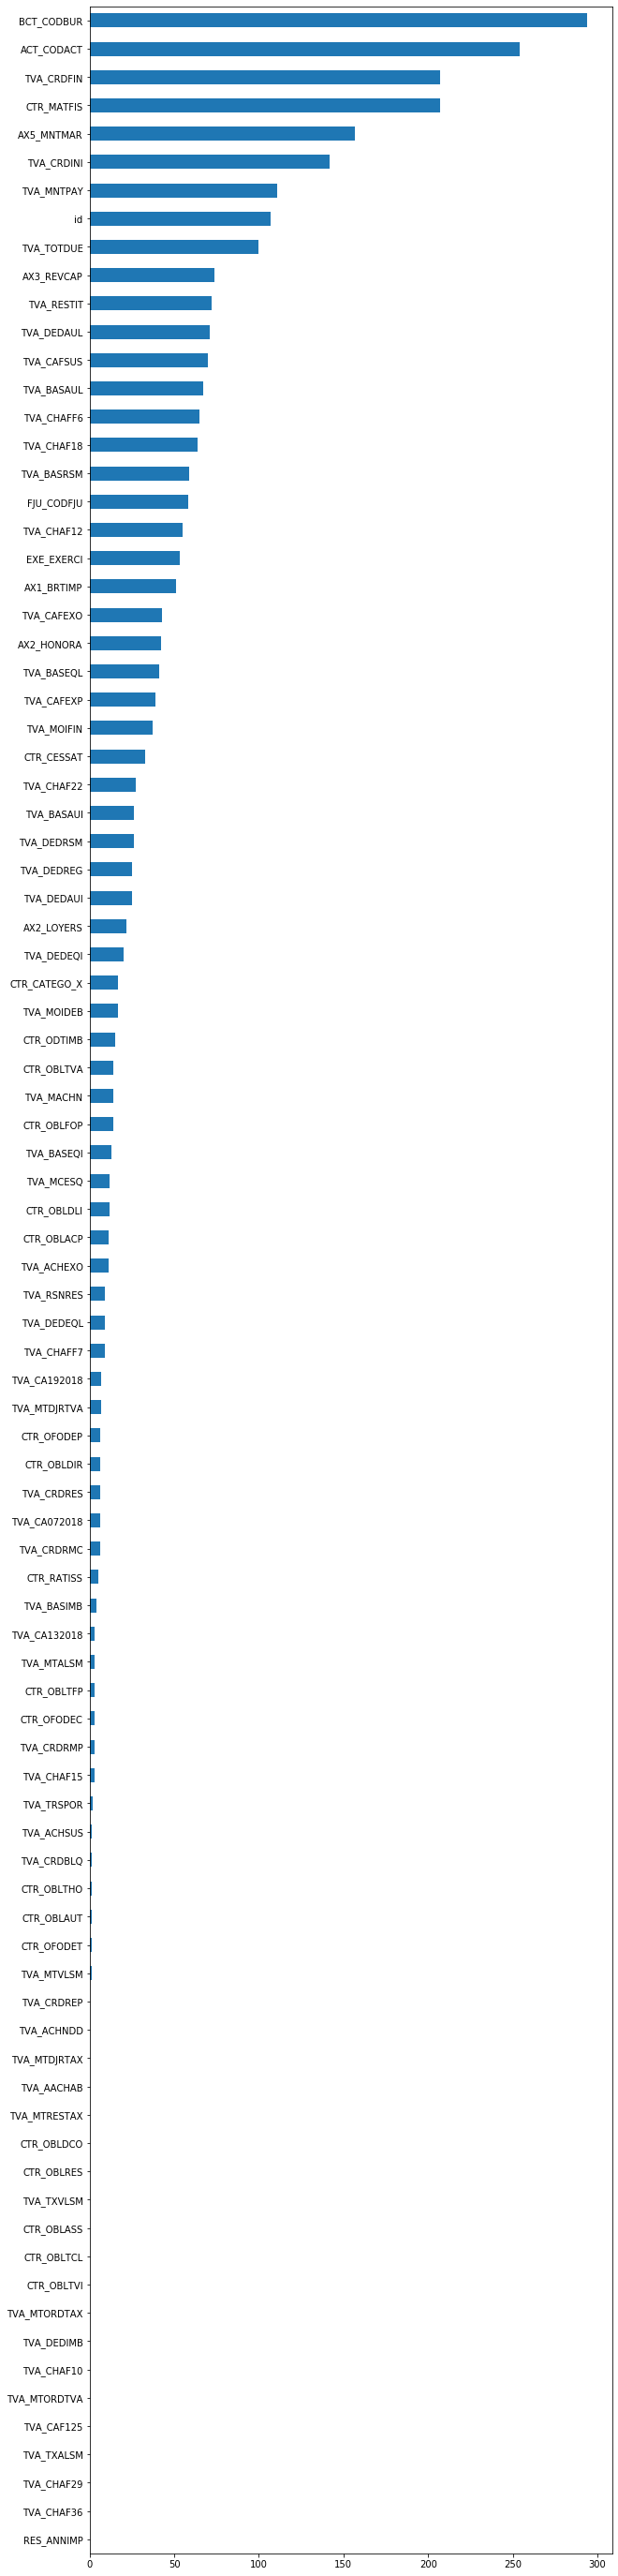

In [62]:
fi = pd.Series(index=features, data= lgb.feature_importances_)
_ = plt.figure(figsize=(10, 50))
_ = fi.sort_values().plot(kind='barh')

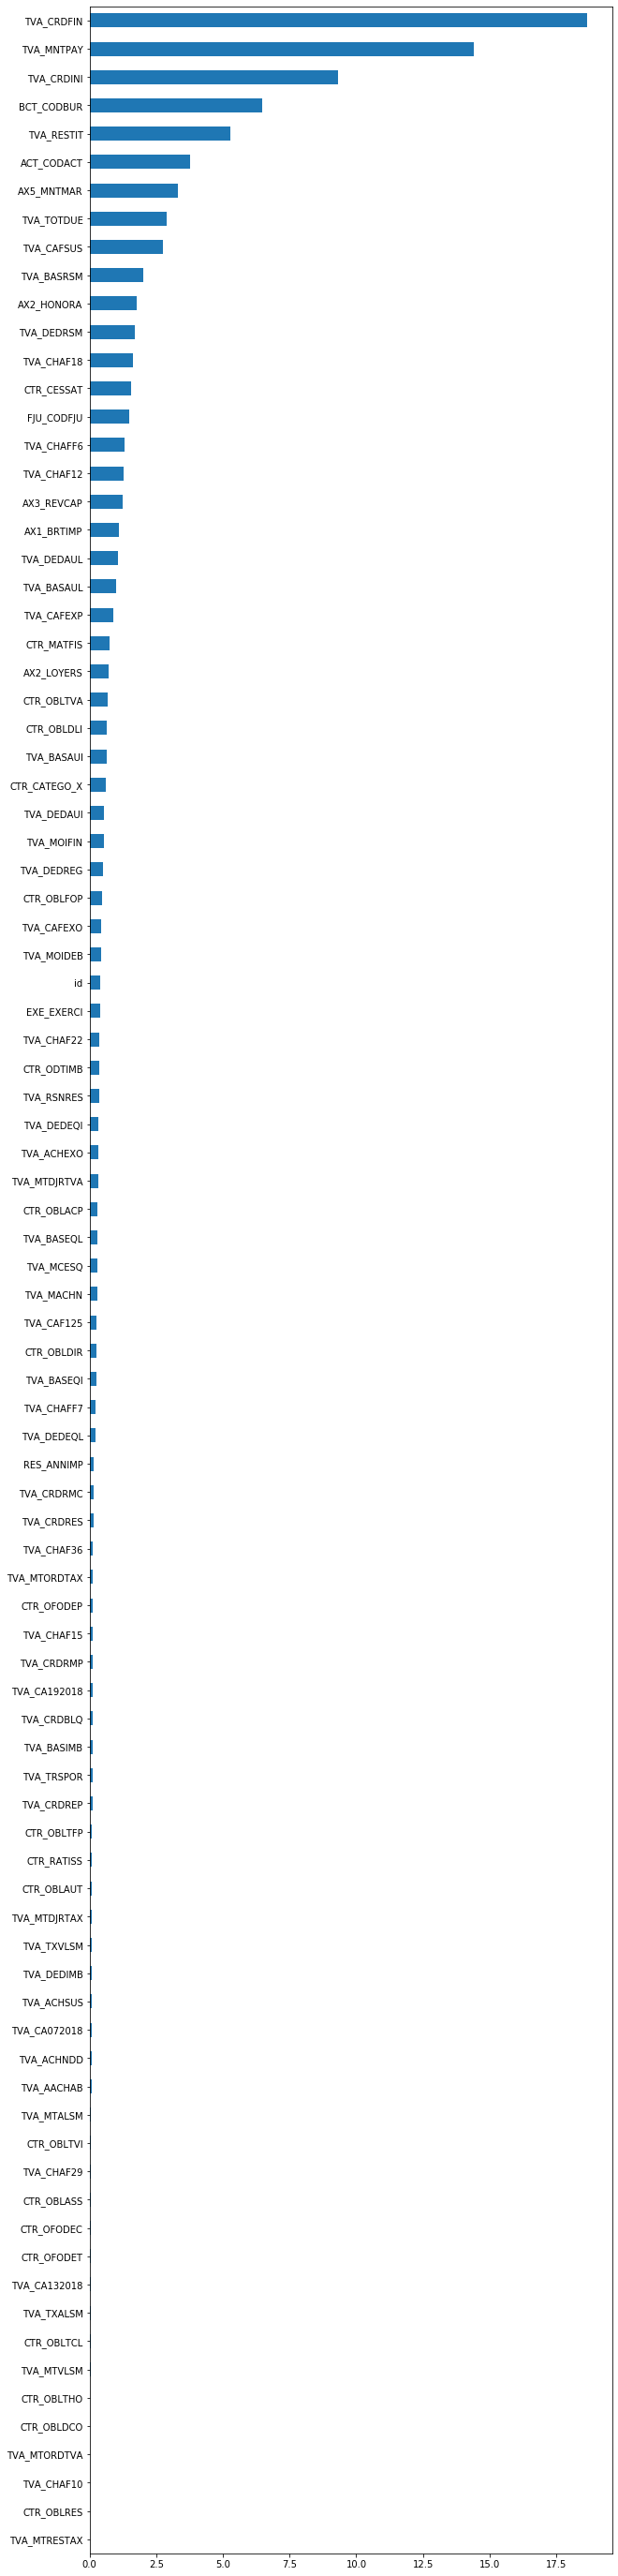

In [63]:
fi = pd.Series(index=features, data= cat.feature_importances_)
_ = plt.figure(figsize=(10, 50))
_ = fi.sort_values().plot(kind='barh')

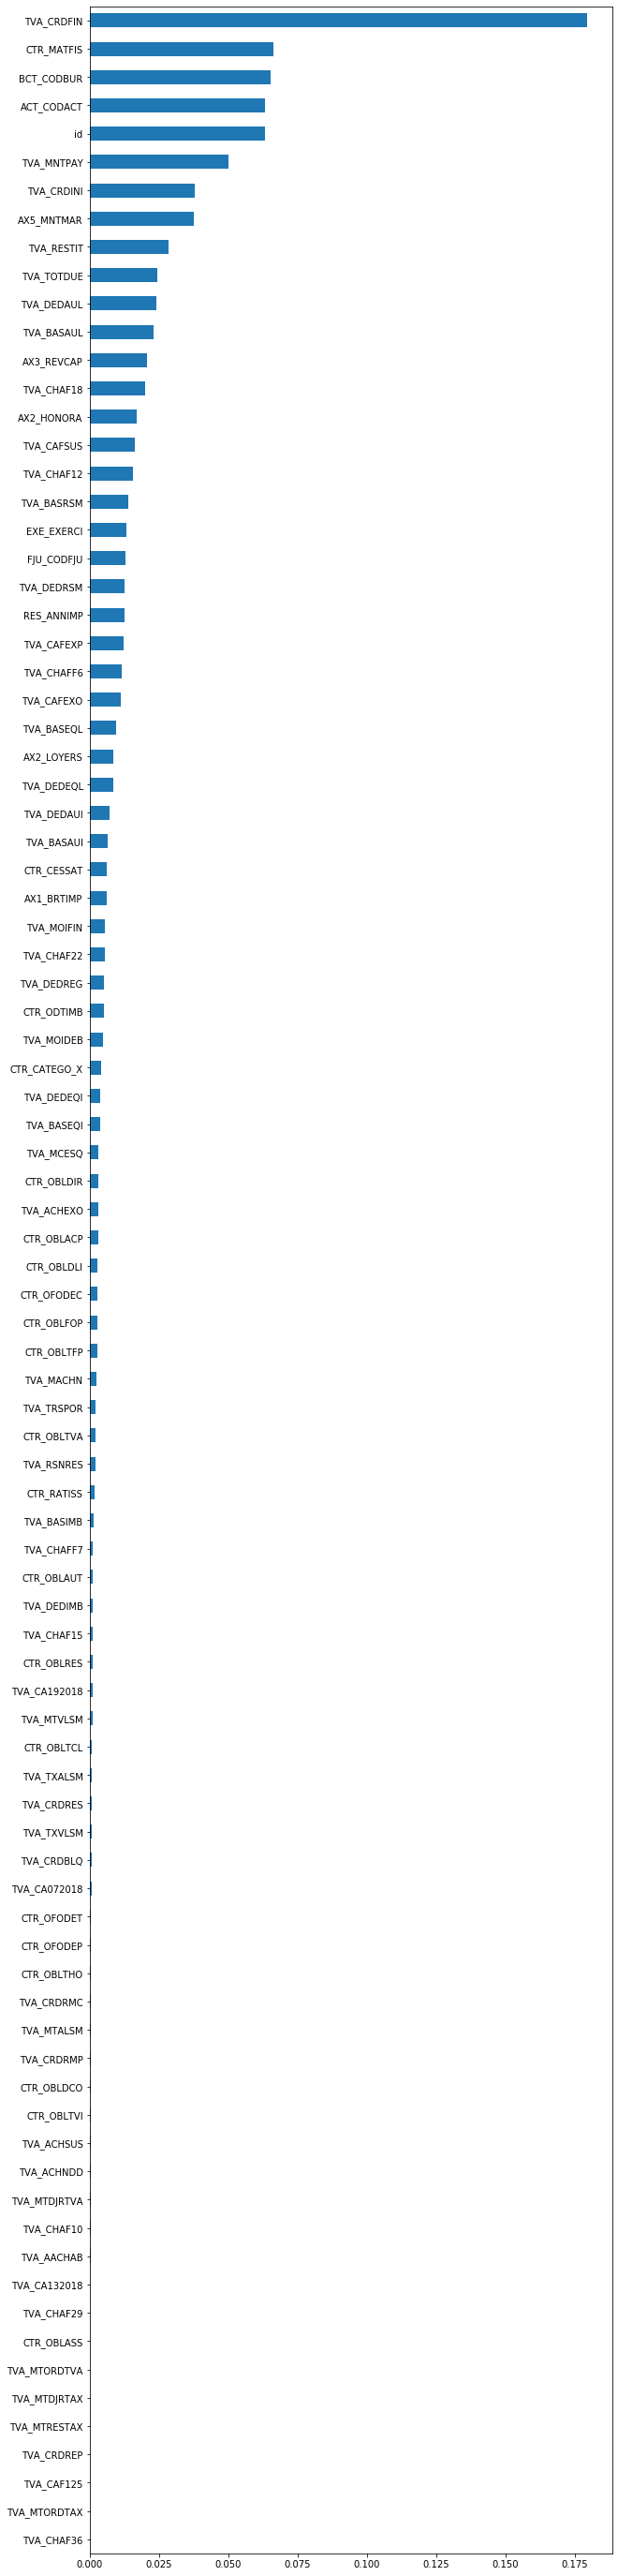

In [64]:
fi = pd.Series(index=features, data= rf.feature_importances_)
_ = plt.figure(figsize=(10, 50))
_ = fi.sort_values().plot(kind='barh')

# Using Xgb CV

In [69]:
validation_score = []
#tym = time()
xgb_tepred = np.zeros(len(test))
xgb_trpred = np.zeros(len(train))

kf = KFold(n_splits = 10, shuffle = False, random_state=50)
for fold,(tr_in,ts_in) in enumerate (kf.split(X)):
    print(f'====================Fold{fold}===========================')
    print('Train:', tr_in, 'Validating:', ts_in)
    X_train,X_test = X.iloc[tr_in],X.iloc[ts_in]
    y_train,y_test = y.iloc[tr_in], y.iloc[ts_in]
    
    #calling the model classifier
    xgb.fit(X_train,y_train, eval_metric='rmse', eval_set = [(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=400)
    
    validation_score.append(rmse(y_test,xgb.predict(X_test)))
    xgb_trpred += xgb.predict(X)
    #xgb_tepred += xgb.predict(test)


C:\Users\bashorun\anaconda33\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


====================Fold0===========================
Train: [ 2506  2507  2508 ... 25050 25051 25052] Validating: [   0    1    2 ... 2503 2504 2505]
[21:01:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12.3237	validation_1-rmse:12.2962
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 400 rounds.
[1]	validation_0-rmse:11.4325	validation_1-rmse:11.4168
[2]	validation_0-rmse:10.6547	validation_1-rmse:10.6501
[3]	validation_0-rmse:9.98003	validation_1-rmse:9.99067
[4]	validation_0-rmse:9.39667	validation_1-rmse:9.41702
[5]	validation_0-rmse:8.89458	validation_1-rmse:8.92198
[6]	validation_0-rmse:8.46427	validation_1-rmse:8.49874
[7]	validation_0-rmse:8.09762	validation_1-rmse:8.14488
[8]	validation_0-rmse:7.78485	validation_1-rmse:7.83823
[9]	validation_0-rmse:7.52262	validation_1-rmse:7.58407
[10]	validatio

[30]	validation_0-rmse:6.16289	validation_1-rmse:6.30535
[31]	validation_0-rmse:6.15476	validation_1-rmse:6.3
[32]	validation_0-rmse:6.14625	validation_1-rmse:6.29465
[33]	validation_0-rmse:6.13658	validation_1-rmse:6.291
[34]	validation_0-rmse:6.13112	validation_1-rmse:6.28827
[35]	validation_0-rmse:6.12449	validation_1-rmse:6.28332
[36]	validation_0-rmse:6.11909	validation_1-rmse:6.27884
[37]	validation_0-rmse:6.11387	validation_1-rmse:6.27545
[38]	validation_0-rmse:6.10689	validation_1-rmse:6.27323
[39]	validation_0-rmse:6.10111	validation_1-rmse:6.27387
[40]	validation_0-rmse:6.09673	validation_1-rmse:6.27115
[41]	validation_0-rmse:6.09244	validation_1-rmse:6.26829
[42]	validation_0-rmse:6.08941	validation_1-rmse:6.26751
[43]	validation_0-rmse:6.08472	validation_1-rmse:6.26491
[44]	validation_0-rmse:6.08126	validation_1-rmse:6.26261
[45]	validation_0-rmse:6.07873	validation_1-rmse:6.26124
[46]	validation_0-rmse:6.07472	validation_1-rmse:6.25887
[47]	validation_0-rmse:6.07013	valida

[67]	validation_0-rmse:6.02497	validation_1-rmse:6.07124
[68]	validation_0-rmse:6.02329	validation_1-rmse:6.0713
[69]	validation_0-rmse:6.0222	validation_1-rmse:6.0707
[70]	validation_0-rmse:6.02031	validation_1-rmse:6.06979
[71]	validation_0-rmse:6.01837	validation_1-rmse:6.06893
[72]	validation_0-rmse:6.01578	validation_1-rmse:6.06758
[73]	validation_0-rmse:6.0139	validation_1-rmse:6.06743
[74]	validation_0-rmse:6.01056	validation_1-rmse:6.06533
[75]	validation_0-rmse:6.00828	validation_1-rmse:6.0652
[76]	validation_0-rmse:6.00453	validation_1-rmse:6.0618
[77]	validation_0-rmse:6.00027	validation_1-rmse:6.05805
[78]	validation_0-rmse:5.99892	validation_1-rmse:6.05785
[79]	validation_0-rmse:5.99661	validation_1-rmse:6.05515
[80]	validation_0-rmse:5.99529	validation_1-rmse:6.05451
[81]	validation_0-rmse:5.99271	validation_1-rmse:6.05251
[82]	validation_0-rmse:5.98846	validation_1-rmse:6.04777
[83]	validation_0-rmse:5.987	validation_1-rmse:6.04709
[84]	validation_0-rmse:5.98503	validati

[0]	validation_0-rmse:12.3261	validation_1-rmse:12.2696
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 400 rounds.
[1]	validation_0-rmse:11.436	validation_1-rmse:11.3816
[2]	validation_0-rmse:10.6581	validation_1-rmse:10.6093
[3]	validation_0-rmse:9.98348	validation_1-rmse:9.93711
[4]	validation_0-rmse:9.40029	validation_1-rmse:9.36046
[5]	validation_0-rmse:8.89807	validation_1-rmse:8.86236
[6]	validation_0-rmse:8.46993	validation_1-rmse:8.44068
[7]	validation_0-rmse:8.10467	validation_1-rmse:8.07817
[8]	validation_0-rmse:7.79269	validation_1-rmse:7.7718
[9]	validation_0-rmse:7.53001	validation_1-rmse:7.51421
[10]	validation_0-rmse:7.3089	validation_1-rmse:7.29847
[11]	validation_0-rmse:7.12218	validation_1-rmse:7.11488
[12]	validation_0-rmse:6.96714	validation_1-rmse:6.96361
[13]	validation_0-rmse:6.8347	validation_1-rmse:6.8343
[14]	validation_0-rmse:6.72532	validation_1-rmse:6.7292
[

[35]	validation_0-rmse:6.14437	validation_1-rmse:6.132
[36]	validation_0-rmse:6.137	validation_1-rmse:6.12358
[37]	validation_0-rmse:6.13023	validation_1-rmse:6.11703
[38]	validation_0-rmse:6.12499	validation_1-rmse:6.1119
[39]	validation_0-rmse:6.12067	validation_1-rmse:6.1088
[40]	validation_0-rmse:6.11599	validation_1-rmse:6.1055
[41]	validation_0-rmse:6.11078	validation_1-rmse:6.10029
[42]	validation_0-rmse:6.10543	validation_1-rmse:6.09463
[43]	validation_0-rmse:6.10122	validation_1-rmse:6.09098
[44]	validation_0-rmse:6.09734	validation_1-rmse:6.08855
[45]	validation_0-rmse:6.0925	validation_1-rmse:6.08471
[46]	validation_0-rmse:6.08735	validation_1-rmse:6.07951
[47]	validation_0-rmse:6.08399	validation_1-rmse:6.07778
[48]	validation_0-rmse:6.08045	validation_1-rmse:6.07417
[49]	validation_0-rmse:6.07857	validation_1-rmse:6.07285
[50]	validation_0-rmse:6.07558	validation_1-rmse:6.07029
[51]	validation_0-rmse:6.07102	validation_1-rmse:6.06509
[52]	validation_0-rmse:6.06911	validati

[72]	validation_0-rmse:6.01493	validation_1-rmse:6.12397
[73]	validation_0-rmse:6.01253	validation_1-rmse:6.12251
[74]	validation_0-rmse:6.00882	validation_1-rmse:6.12063
[75]	validation_0-rmse:6.00694	validation_1-rmse:6.11954
[76]	validation_0-rmse:6.00302	validation_1-rmse:6.1171
[77]	validation_0-rmse:6.00029	validation_1-rmse:6.11492
[78]	validation_0-rmse:5.99775	validation_1-rmse:6.11379
[79]	validation_0-rmse:5.99529	validation_1-rmse:6.11113
[80]	validation_0-rmse:5.99183	validation_1-rmse:6.11034
[81]	validation_0-rmse:5.99006	validation_1-rmse:6.10929
[82]	validation_0-rmse:5.98896	validation_1-rmse:6.10965
[83]	validation_0-rmse:5.98698	validation_1-rmse:6.1082
[84]	validation_0-rmse:5.98587	validation_1-rmse:6.10839
[85]	validation_0-rmse:5.98404	validation_1-rmse:6.10873
[86]	validation_0-rmse:5.98183	validation_1-rmse:6.10705
[87]	validation_0-rmse:5.97971	validation_1-rmse:6.10316
[88]	validation_0-rmse:5.97805	validation_1-rmse:6.10216
[89]	validation_0-rmse:5.97678	va

[2]	validation_0-rmse:10.6443	validation_1-rmse:10.8349
[3]	validation_0-rmse:9.97431	validation_1-rmse:10.1533
[4]	validation_0-rmse:9.39521	validation_1-rmse:9.55975
[5]	validation_0-rmse:8.89711	validation_1-rmse:9.04485
[6]	validation_0-rmse:8.47065	validation_1-rmse:8.60154
[7]	validation_0-rmse:8.10786	validation_1-rmse:8.22454
[8]	validation_0-rmse:7.79871	validation_1-rmse:7.89799
[9]	validation_0-rmse:7.53599	validation_1-rmse:7.61858
[10]	validation_0-rmse:7.31537	validation_1-rmse:7.38581
[11]	validation_0-rmse:7.13132	validation_1-rmse:7.19026
[12]	validation_0-rmse:6.97638	validation_1-rmse:7.01861
[13]	validation_0-rmse:6.84754	validation_1-rmse:6.87785
[14]	validation_0-rmse:6.7401	validation_1-rmse:6.75595
[15]	validation_0-rmse:6.64828	validation_1-rmse:6.65097
[16]	validation_0-rmse:6.57163	validation_1-rmse:6.56105
[17]	validation_0-rmse:6.50881	validation_1-rmse:6.48646
[18]	validation_0-rmse:6.45629	validation_1-rmse:6.42659
[19]	validation_0-rmse:6.41104	validatio

[40]	validation_0-rmse:6.09879	validation_1-rmse:6.31469
[41]	validation_0-rmse:6.09599	validation_1-rmse:6.31425
[42]	validation_0-rmse:6.09044	validation_1-rmse:6.31074
[43]	validation_0-rmse:6.08615	validation_1-rmse:6.30829
[44]	validation_0-rmse:6.081	validation_1-rmse:6.3071
[45]	validation_0-rmse:6.0763	validation_1-rmse:6.30261
[46]	validation_0-rmse:6.07361	validation_1-rmse:6.30148
[47]	validation_0-rmse:6.07061	validation_1-rmse:6.29824
[48]	validation_0-rmse:6.06672	validation_1-rmse:6.29566
[49]	validation_0-rmse:6.06511	validation_1-rmse:6.29431
[50]	validation_0-rmse:6.06058	validation_1-rmse:6.29266
[51]	validation_0-rmse:6.05709	validation_1-rmse:6.29081
[52]	validation_0-rmse:6.05422	validation_1-rmse:6.28904
[53]	validation_0-rmse:6.04949	validation_1-rmse:6.28487
[54]	validation_0-rmse:6.04701	validation_1-rmse:6.284
[55]	validation_0-rmse:6.04145	validation_1-rmse:6.27864
[56]	validation_0-rmse:6.03903	validation_1-rmse:6.27787
[57]	validation_0-rmse:6.03606	valida

In [70]:
np.mean(validation_score)

6.089780518072105